# Preamble: Packages and Functions

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
from collections import Counter
from statistics import mode
import numpy as np
import os
import PIL
import time
import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn import preprocessing
import matplotlib . pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def custom_scale(X_1,X_base):
    scaler = StandardScaler()
    scaler.fit(X_base)
    X_custom_scaled = scaler.transform(X_1)
    
    return X_custom_scaled

# Task 0: Preprocessing

Comment: **shared_file_groups_habitat_disturbed.csv**  contains the sampleIDs and their respective habitat (i.e. class) labels. Use this rather than the LOI_div2_combined.txt file

In [2]:
df_taxonomy = pd.read_csv('V6otu.nr_v123.wang.taxonomy.csv').dropna().reset_index()
df_lefse = pd.read_csv('Lefse_output.csv').dropna().reset_index()
df_correct_habitats = pd.read_csv('shared_file_groups_habitat_disturbed.csv').dropna().reset_index()
df_process_raw = pd.read_csv('LOI_div2_combined.txt',sep ='\t',lineterminator='\r').dropna().reset_index()

# Correct habitat labels in the LOD_div file
habitats_old = df_process_raw[['SampleID','Habitat']]
habitats_longlist = df_correct_habitats[['SampleID','Habitat']]
habitats_correct = pd.merge(habitats_old,habitats_longlist,how='left',left_on=['SampleID'], right_on=['SampleID'])
df_process_raw['Habitat'] = habitats_correct['Habitat_y']

del df_process_raw['index']
df_process_raw

,SampleID,SiteID,Layer,Moisture,SOM,SOC,New_Layer,Lake,Lat,Long,Habitat,sobs,chao,coverage,shannon,simpson
0,10A2,10A,2.0,25.676816,21.220681,12.308980,Shallow,Polley_Lake,52.53216,-121.58716,B,838.0,1969.239316,0.822353,5.704564,0.009452
1,10A3,10A,3.0,8.811604,10.479796,6.078768,Deep,Polley_Lake,52.53216,-121.58716,B,1307.0,3846.558659,0.667596,6.350891,0.007115
2,10A4,10A,4.0,8.596961,3.095402,1.795477,Deep,Polley_Lake,52.53216,-121.58716,B,864.0,2154.618321,0.798127,5.562425,0.012470
3,10A5,10A,5.0,26.531726,7.354307,4.265839,Sediment,Polley_Lake,52.53216,-121.58716,B,507.0,1228.444444,0.898179,4.474553,0.044446
4,10A6,10A,6.0,21.921871,4.207926,2.440792,Sediment,Polley_Lake,52.53216,-121.58716,B,553.0,1215.012195,0.888174,4.781864,0.031322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,9A1,9A,1.0,28.263441,27.937755,16.205195,Shallow,Polley_Lake,52.53321,-121.58467,C,1577.0,3958.607547,0.589181,6.951618,0.002122
156,9A3,9A,3.0,31.791771,56.928094,33.020936,Deep,Polley_Lake,52.53321,-121.58467,C,1574.0,4257.792373,0.590545,6.981759,0.001583
157,9A4,9A,4.0,17.774114,16.186807,9.389099,Deep,Polley_Lake,52.53321,-121.58467,C,1593.0,4625.120536,0.577230,6.975727,0.001695
158,9A5,9A,5.0,13.540520,15.770225,9.147463,Sediment,Polley_Lake,52.53321,-121.58467,C,1158.0,2624.201117,0.745792,6.379359,0.004274


### Only keep indicators with p-values less than 0.01

In [4]:
df_lefse_curated = df_lefse [ df_lefse["pValue"] < 0.01 ]
df_lefse_curated

,index,OTU,LogMaxMean,Class,LDA,pValue
1,5,OTU140,3.03527,Disturbed,2.40347,7.480000e-03
2,7,OTU933,2.58703,Natural,2.65299,1.422990e-04
3,14,OTU52,3.55448,Disturbed,2.89006,5.401490e-03
4,15,OTU31,3.90160,Natural,3.60012,9.120000e-09
5,17,OTU2711,3.51761,Natural,3.20682,1.069290e-04
...,...,...,...,...,...,...
176,1282,OTU332,2.82555,Natural,2.72668,1.250000e-06
177,1300,OTU94,3.35365,Disturbed,3.08405,2.900000e-11
178,1501,OTU17,3.78996,Disturbed,3.55686,1.070000e-13
179,1587,OTU83,3.34626,Disturbed,3.15898,4.420000e-14


### 0.1: Interrogate the categorical features to figure out how many unique values exist in each.

In [5]:
print(df_process_raw['Layer'].unique())
print(df_process_raw['New_Layer'].unique())
print(df_process_raw['Lake'].unique())
print(df_process_raw['Habitat'].unique())

[2. 3. 4. 5. 6. 1.]
['Shallow' 'Deep' 'Sediment']
['Polley_Lake' 'Quesnel_Lake' 'BootJack_Lake' 'Hazeltine_Creek']
['B' 'A' 'E' 'C' 'D' 'F']


### 0.2: Load in OTU data

In [6]:
df_bio = pd.read_csv('otu_table_3000_Jan8_4pm.txt',sep ='\t',lineterminator='\r').dropna()
df_bio

## Grab SampleID values and match their format to agree with raw process table

df_bio_index_raw = df_bio.index
N_bio = df_bio.index.shape[0]
df_bio_index = []

# Remove '\n' delimiters
for ii in range(0,N_bio):
    df_bio_index.append(df_bio_index_raw[ii].replace('\n',''))

# Remove double quotation marks ""
for ii in range(0,N_bio):
    df_bio_index[ii] = df_bio_index[ii].replace('"','')

# Append SampleID column to bio table:
df_bio.insert(0,'SampleID',df_bio_index)

# Drop NA cells and reset index
df_bio = df_bio.reset_index()
del df_bio['index']
df_bio

,SampleID,OTU279,OTU452,OTU60,OTU765,OTU822,OTU1459,OTU1096,OTU1451,OTU4067,...,OTU23134,OTU23202,OTU25563,OTU25963,OTU21460,OTU23059,OTU21767,OTU21412,OTU22718,OTU22404
0,10A2,35.0,23.0,3.0,0.0,0.0,2.0,1.0,7.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10A3,3.0,12.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10A4,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10A5,1.0,7.0,2.0,0.0,0.0,0.0,0.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10A6,3.0,43.0,0.0,0.0,0.0,0.0,2.0,11.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,9A1,0.0,1.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
215,9A3,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,9A4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
217,9A5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,3.0


### Compute the abundance sums across all the rows, for all OTUs

In [7]:
OTU_sums = np.sum(df_bio.loc[:,'OTU279':],axis=0)
OTU_sums

OTU279      206.0
OTU452      153.0
OTU60       920.0
OTU765       60.0
OTU822       42.0
            ...  
OTU23059      3.0
OTU21767      4.0
OTU21412      4.0
OTU22718      3.0
OTU22404      4.0
Length: 21721, dtype: float64

### Identify the top 50 OTUs based on raw abundance sums

In [8]:
OTU_sums_array = -OTU_sums.values
top_OTU_indices = OTU_sums_array.argsort()
top_50_OTU_indices = top_OTU_indices[0:50]

original_OTU_columns = df_bio.columns[1:]
top_50_OTU = original_OTU_columns[top_50_OTU_indices]
top_50_OTU

Index(['OTU1', 'OTU2', 'OTU3', 'OTU6', 'OTU4', 'OTU5', 'OTU11', 'OTU31',
       'OTU54', 'OTU15', 'OTU10', 'OTU41', 'OTU25', 'OTU52', 'OTU8', 'OTU18',
       'OTU102', 'OTU53', 'OTU1873', 'OTU66', 'OTU2711', 'OTU13', 'OTU12',
       'OTU62', 'OTU7', 'OTU17', 'OTU2030', 'OTU38', 'OTU23', 'OTU16618',
       'OTU16', 'OTU22', 'OTU21', 'OTU39', 'OTU1781', 'OTU9', 'OTU65', 'OTU42',
       'OTU29', 'OTU30', 'OTU172', 'OTU20', 'OTU19', 'OTU54188', 'OTU88',
       'OTU26', 'OTU14', 'OTU51', 'OTU158', 'OTU178'],
      dtype='object')

### From the original OTU abundance table, select only the top 50 OTUs

In [9]:
df_bio_curated = df_bio.copy()
df_bio_curated = df_bio_curated[top_50_OTU]

# Add SampleID column
df_bio_curated.insert(0,'SampleID',df_bio['SampleID'])
df_bio_curated

,SampleID,OTU1,OTU2,OTU3,OTU6,OTU4,OTU5,OTU11,OTU31,OTU54,...,OTU172,OTU20,OTU19,OTU54188,OTU88,OTU26,OTU14,OTU51,OTU158,OTU178
0,10A2,0.0,0.0,0.0,26.0,1.0,89.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,108.0,2.0,0.0,10.0,1.0
1,10A3,10.0,0.0,12.0,22.0,2.0,152.0,11.0,8.0,2.0,...,6.0,0.0,3.0,1.0,3.0,11.0,0.0,0.0,16.0,1.0
2,10A4,0.0,0.0,0.0,37.0,0.0,124.0,13.0,0.0,6.0,...,3.0,2.0,7.0,0.0,0.0,2.0,0.0,0.0,58.0,2.0
3,10A5,0.0,0.0,0.0,11.0,0.0,501.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0
4,10A6,0.0,0.0,0.0,2.0,1.0,432.0,0.0,1.0,0.0,...,1.0,25.0,0.0,0.0,1.0,17.0,11.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,9A1,0.0,4.0,63.0,9.0,0.0,7.0,5.0,9.0,6.0,...,7.0,2.0,2.0,8.0,3.0,0.0,0.0,1.0,2.0,8.0
215,9A3,2.0,0.0,27.0,0.0,0.0,3.0,10.0,57.0,11.0,...,41.0,2.0,6.0,2.0,3.0,1.0,0.0,0.0,1.0,6.0
216,9A4,0.0,0.0,31.0,5.0,0.0,0.0,2.0,61.0,3.0,...,22.0,3.0,17.0,0.0,6.0,0.0,0.0,1.0,0.0,5.0
217,9A5,1.0,0.0,73.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0


## 0.3 Plot distribution of remaining OTUs

First print summary statistics of the curated OTUs.

In [10]:
#df_bio_curated.describe()

curated_abundances = df_bio_curated.loc[:,'OTU1':].values
print(np.max(curated_abundances))
print(np.min(curated_abundances))

1344.0
0.0


C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Overall Distribution of Log-Transformed OTU Abundance Counts')

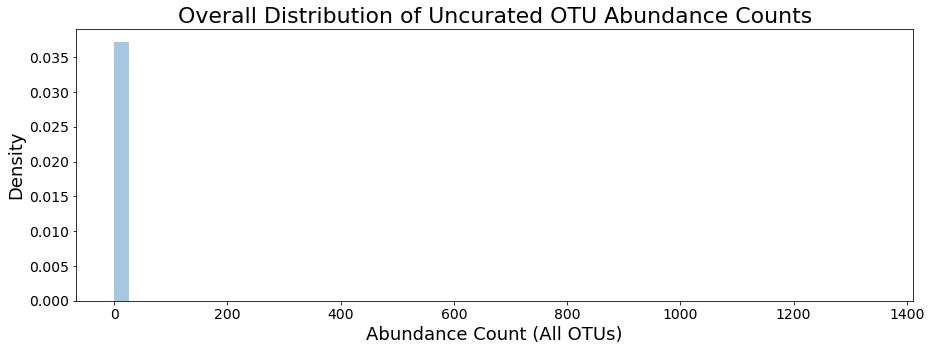

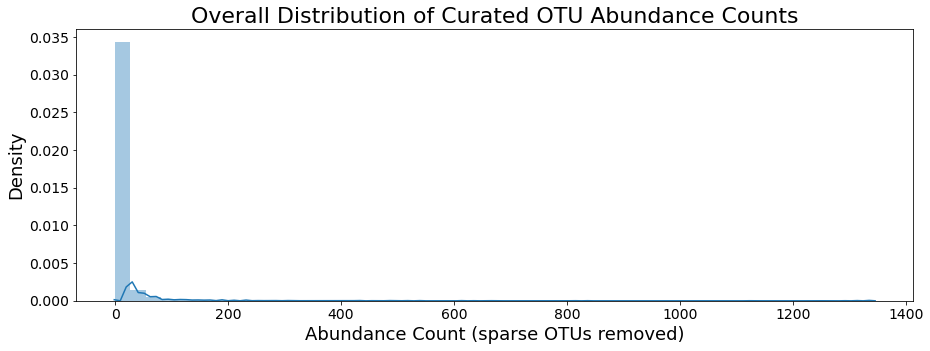

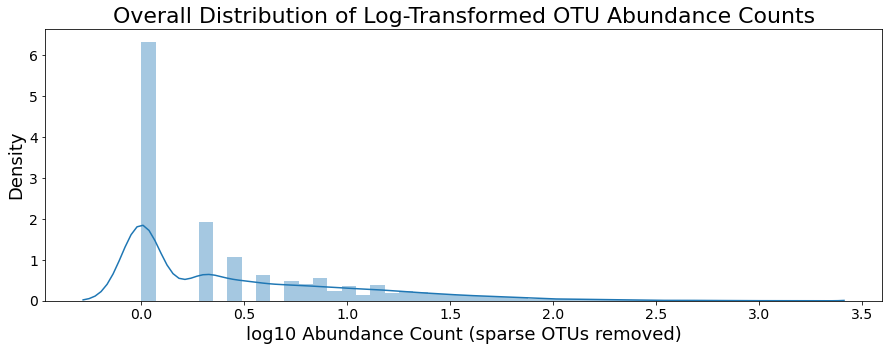

In [11]:
uncurated_abundances = df_bio.loc[:,'OTU279':].values
uncurated_abundances_distr = uncurated_abundances.reshape(-1,1)

curated_abundances_distr = curated_abundances.reshape(-1,1)

# For log10 operation, first add 0.01 to all values to avoid taking log of zero
eps = 1
curated_abundances_distr_log10 = np.log10(curated_abundances_distr + eps)

# Do the same operation for the original abundance matrices
curated_abundances_eps = curated_abundances + eps
curated_abundances_log10 = np.log10(curated_abundances_eps)

plt.figure(figsize=(15,5))
sns.distplot(uncurated_abundances_distr)
plt.xlabel("Abundance Count (All OTUs)",fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=14)
plt.title("Overall Distribution of Uncurated OTU Abundance Counts",fontsize=22)

plt.figure(figsize=(15,5))
sns.distplot(curated_abundances_distr)
plt.xlabel("Abundance Count (sparse OTUs removed)",fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=14)
plt.title("Overall Distribution of Curated OTU Abundance Counts",fontsize=22)

plt.figure(figsize=(15,5))
sns.distplot(curated_abundances_distr_log10)
plt.xlabel("log10 Abundance Count (sparse OTUs removed)",fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=14)
plt.title("Overall Distribution of Log-Transformed OTU Abundance Counts",fontsize=22)

### Basic sanity checks

In [16]:
np.max(curated_abundances_distr_log10)

3.128722284338427

In [17]:
np.max(curated_abundances)

1344.0

In [18]:
curated_abundances_log10.shape

(219, 50)

In [19]:
df_bio_curated.shape

(219, 51)

## 0.4: If everything above looks OK, combine process and OTU tables.

In [20]:
# Now combine process and bio dataframes, matching them by SampleID:
df_merged_raw = pd.merge(df_process_raw,df_bio_curated,how='left',left_on=['SampleID'], right_on=['SampleID'])
df_merged_raw = df_merged_raw.dropna() # Some samples in chem data are not in bio data
df_merged_raw

,SampleID,SiteID,Layer,Moisture,SOM,SOC,New_Layer,Lake,Lat,Long,...,OTU172,OTU20,OTU19,OTU54188,OTU88,OTU26,OTU14,OTU51,OTU158,OTU178
0,10A2,10A,2.0,25.676816,21.220681,12.308980,Shallow,Polley_Lake,52.53216,-121.58716,...,0.0,1.0,1.0,0.0,0.0,108.0,2.0,0.0,10.0,1.0
1,10A3,10A,3.0,8.811604,10.479796,6.078768,Deep,Polley_Lake,52.53216,-121.58716,...,6.0,0.0,3.0,1.0,3.0,11.0,0.0,0.0,16.0,1.0
2,10A4,10A,4.0,8.596961,3.095402,1.795477,Deep,Polley_Lake,52.53216,-121.58716,...,3.0,2.0,7.0,0.0,0.0,2.0,0.0,0.0,58.0,2.0
3,10A5,10A,5.0,26.531726,7.354307,4.265839,Sediment,Polley_Lake,52.53216,-121.58716,...,0.0,1.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0
4,10A6,10A,6.0,21.921871,4.207926,2.440792,Sediment,Polley_Lake,52.53216,-121.58716,...,1.0,25.0,0.0,0.0,1.0,17.0,11.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,9A1,9A,1.0,28.263441,27.937755,16.205195,Shallow,Polley_Lake,52.53321,-121.58467,...,7.0,2.0,2.0,8.0,3.0,0.0,0.0,1.0,2.0,8.0
156,9A3,9A,3.0,31.791771,56.928094,33.020936,Deep,Polley_Lake,52.53321,-121.58467,...,41.0,2.0,6.0,2.0,3.0,1.0,0.0,0.0,1.0,6.0
157,9A4,9A,4.0,17.774114,16.186807,9.389099,Deep,Polley_Lake,52.53321,-121.58467,...,22.0,3.0,17.0,0.0,6.0,0.0,0.0,1.0,0.0,5.0
158,9A5,9A,5.0,13.540520,15.770225,9.147463,Sediment,Polley_Lake,52.53321,-121.58467,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0


In [21]:
df_merged_raw.loc[:,'Habitat':'Habitat']

,Habitat
0,B
1,B
2,B
3,B
4,B
...,...
155,C
156,C
157,C
158,C


In [22]:
df_merged_raw.columns[0:20]

Index(['SampleID', 'SiteID', 'Layer', 'Moisture', 'SOM', 'SOC', 'New_Layer',
       'Lake', 'Lat', 'Long', 'Habitat', 'sobs', 'chao', 'coverage', 'shannon',
       'simpson', 'OTU1', 'OTU2', 'OTU3', 'OTU6'],
      dtype='object')

In [23]:
df_merged_raw['Lake'].unique()

array(['Polley_Lake', 'Quesnel_Lake', 'BootJack_Lake', 'Hazeltine_Creek'],
      dtype=object)

In [24]:
# Save as CSV file
df_merged_raw.to_csv('preprocessed_top50.csv')

# Task 1: Visualizing raw OTU count distribution

First, plot the $max$ OTU counts across all species.

Text(0, 0.5, 'Max count')

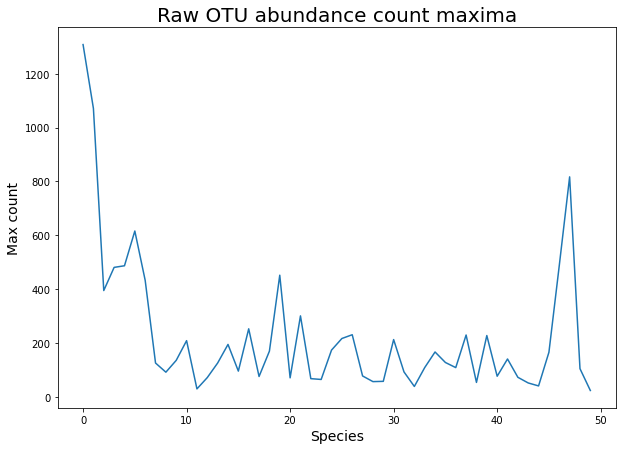

In [25]:
OTU_df = df_merged_raw.loc[:,'OTU1':]
OTU_df_max_values = np.max(OTU_df)

plt.figure(figsize=(10,7))
plt.plot(OTU_df_max_values.values)

plt.title("Raw OTU abundance count maxima", fontsize=20)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Max count", fontsize = 14)


Specify a max cut-off value, then report the OTU species which exceed said cut-off.

In [26]:
max_cutoff = 500
OTU_species = OTU_df.columns

abundant_species = OTU_species[OTU_df_max_values >= max_cutoff]
print(abundant_species)

Index(['OTU1', 'OTU2', 'OTU5', 'OTU51'], dtype='object')


Make a histogram of max values for each OTU species, with bins ranging with powers of $10$, i.e. $0 \sim 10$, $10 \sim 100$, $100 \sim 1000$, and $1000 \sim 10000$.

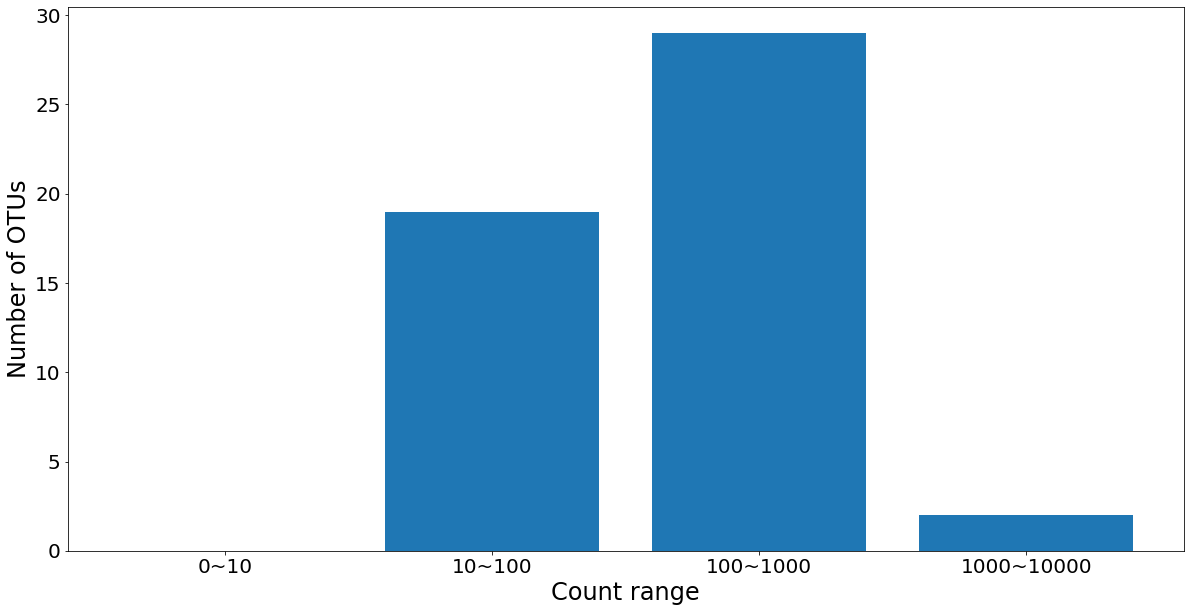

In [27]:
total = OTU_species.shape[0]

bin_0 = 0
bin_1 = 10**1
bin_2 = 10**2
bin_3 = 10**3
bin_4 = 10**4

num_34 = np.sum(OTU_df_max_values >= bin_3)
num_234 = np.sum(OTU_df_max_values >= bin_2)
num_23 = num_234 - num_34
num_1234 = np.sum(OTU_df_max_values >= bin_1)
num_12 = num_1234 - num_234
num_01 = total - num_1234

# Sanity check: should print TRUE
num_01 + num_12 + num_23 + num_34 == total

# Histogram

powers = np.arange(0,4,1)
numbers = np.asarray([num_01,num_12,num_23,num_34])
xames = ["0~10","10~100","100~1000","1000~10000"]

plt.figure(figsize=(20,10))
plt.rc("font", size=20)
plt.bar(powers,numbers)
plt.xticks(powers,xames)
plt.xlabel("Count range",fontsize=24)
plt.ylabel("Number of OTUs",fontsize=24)
#plt.yticks(np.arange(0,25,step=5),fontsize=20)
#plt.title("Cluster population histogram")
plt.show()

# Final preprocessing steps before modelling

In [31]:
# What are the macro features?
df_merged_raw.columns[0:16]

# Take data from only the curated OTU columns.
OTU_columns = df_merged_raw.columns[16:]
df_OTU_only = df_merged_raw.loc[:,OTU_columns]

First, add $1$ to all the raw abundance counts, then perform a $log_{10}$ transformation.

In [32]:
df_OTU_only_log10 = np.log10( df_OTU_only + 1 )

Then, grab the target variables (habitat classes) from the original dataframe. Assemble the raw $X$ and $y$ matrices; recall that habitat classes $A$~$C$ belong in Class $0$, and vice versa for the remainder.

In [33]:
y_raw = df_merged_raw.loc[:,'Habitat'].values
y = np.zeros((y_raw.shape[0],))

for i in range(0,y_raw.shape[0]):
    if y_raw[i] == 'D' or y_raw[i] == 'E' or y_raw[i] == 'F':
        y[i] = 1

X_raw = df_OTU_only_log10.values

y_orig = np.zeros((y_raw.shape[0],))
for i in range(0,y_raw.shape[0]):
    if y_raw[i] == 'B':
        y_orig[i] = 1
    if y_raw[i] == 'C':
        y_orig[i] = 2
    if y_raw[i] == 'D':
        y_orig[i] = 3
    if y_raw[i] == 'E':
        y_orig[i] = 4
    if y_raw[i] == 'F':
        y_orig[i] = 5
        
X_0 = X_raw[y_orig == 0]
X_5 = X_raw[y_orig == 5]

X_small = np.concatenate((X_0,X_5))

y_0 = y_orig[y_orig == 0]
y_5 = y_orig[y_orig == 5]

y_small = np.concatenate((y_0,y_5))
N = y_small.shape[0]

y = np.zeros((N,))

# Relabel classes so that they either belong to 0 or 1
for i in range(0,N):
    if y_small[i] == 5:
        y[i] = 1